In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy as sp
from scipy.ndimage.filters import gaussian_filter1d
import sqlite3 as sql
import os
import pandas as pd
from datetime import datetime
from glob import glob
os.sys.path.append('../')
from utilities import *
from single_session_plots import *

from astropy.convolution import convolve, Gaussian1DKernel

import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

%load_ext autoreload
%autoreload 2

%matplotlib inline

C:\Users\mplitt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# import data
mouse = '4139190.1'
df = load_session_db()
#ca1mice = ['4139190.1','4139190.3', '4054011.1','4139202.2']
#dgmice = ['4054010.4','4054010.5']


df = df[df['RewardCount']>10]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime'])

df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_Timeout')]
df_mouse = df_mouse.sort_values(['DateTime'])
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,DateTime,data file,scanfile,scanmat
150,4139190.1,16_06_2018,2,TwoTower_Timeout,19,1,2018-06-16,G:\My Drive\\VR_Data\TwoTower\4139190.1\16_06_...,G:\My Drive\2P_Data\TwoTower\4139190.1\16_06_2...,G:\My Drive\2P_Data\TwoTower\4139190.1\16_06_2...
210,4139190.1,19_06_2018,2,TwoTower_Timeout,75,1,2018-06-19,G:\My Drive\\VR_Data\TwoTower\4139190.1\19_06_...,G:\My Drive\2P_Data\TwoTower\4139190.1\19_06_2...,G:\My Drive\2P_Data\TwoTower\4139190.1\19_06_2...
175,4139190.1,21_06_2018,3,TwoTower_Timeout,92,1,2018-06-21,G:\My Drive\\VR_Data\TwoTower\4139190.1\21_06_...,G:\My Drive\2P_Data\TwoTower\4139190.1\21_06_2...,G:\My Drive\2P_Data\TwoTower\4139190.1\21_06_2...
177,4139190.1,21_06_2018,2,TwoTower_Timeout,20,1,2018-06-21,G:\My Drive\\VR_Data\TwoTower\4139190.1\21_06_...,G:\My Drive\2P_Data\TwoTower\4139190.1\21_06_2...,G:\My Drive\2P_Data\TwoTower\4139190.1\21_06_2...
169,4139190.1,24_06_2018,2,TwoTower_Timeout,104,1,2018-06-24,G:\My Drive\\VR_Data\TwoTower\4139190.1\24_06_...,G:\My Drive\2P_Data\TwoTower\4139190.1\24_06_2...,G:\My Drive\2P_Data\TwoTower\4139190.1\24_06_2...
173,4139190.1,25_06_2018,2,TwoTower_Timeout,62,1,2018-06-25,G:\My Drive\\VR_Data\TwoTower\4139190.1\25_06_...,G:\My Drive\2P_Data\TwoTower\4139190.1\25_06_2...,G:\My Drive\2P_Data\TwoTower\4139190.1\25_06_2...
205,4139190.1,27_06_2018,2,TwoTower_Timeout,81,1,2018-06-27,G:\My Drive\\VR_Data\TwoTower\4139190.1\27_06_...,G:\My Drive\2P_Data\TwoTower\4139190.1\27_06_2...,G:\My Drive\2P_Data\TwoTower\4139190.1\27_06_2...
160,4139190.1,28_06_2018,8,TwoTower_Timeout,22,1,2018-06-28,G:\My Drive\\VR_Data\TwoTower\4139190.1\28_06_...,G:\My Drive\2P_Data\TwoTower\4139190.1\28_06_2...,G:\My Drive\2P_Data\TwoTower\4139190.1\28_06_2...
164,4139190.1,28_06_2018,2,TwoTower_Timeout,17,1,2018-06-28,G:\My Drive\\VR_Data\TwoTower\4139190.1\28_06_...,G:\My Drive\2P_Data\TwoTower\4139190.1\28_06_2...,G:\My Drive\2P_Data\TwoTower\4139190.1\28_06_2...
165,4139190.1,28_06_2018,9,TwoTower_Timeout,18,1,2018-06-28,G:\My Drive\\VR_Data\TwoTower\4139190.1\28_06_...,G:\My Drive\2P_Data\TwoTower\4139190.1\28_06_2...,G:\My Drive\2P_Data\TwoTower\4139190.1\28_06_2...


In [3]:
# select session
sess = df_mouse.iloc[4]
sess

MouseName                                                4139190.1
DateFolder                                              24_06_2018
SessionNumber                                                    2
Track                                             TwoTower_Timeout
RewardCount                                                    104
Imaging                                                          1
DateTime                                       2018-06-24 00:00:00
data file        G:\My Drive\\VR_Data\TwoTower\4139190.1\24_06_...
scanfile         G:\My Drive\2P_Data\TwoTower\4139190.1\24_06_2...
scanmat          G:\My Drive\2P_Data\TwoTower\4139190.1\24_06_2...
Name: 169, dtype: object

G:\My Drive\2P_Data\TwoTower\4139190.1\24_06_2018\TwoTower_Timeout\TwoTower_Timeout_2_000.mat


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame['ca inds'] = caInds
C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\mplitt\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:478: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_m

G:\My Drive\2P_Data\TwoTower\4139190.1\24_06_2018\TwoTower_Timeout\TwoTower_Timeout_2_000.mat
#subsystem#not made into numpy array


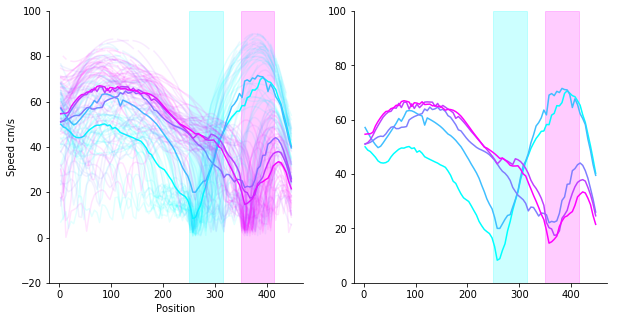

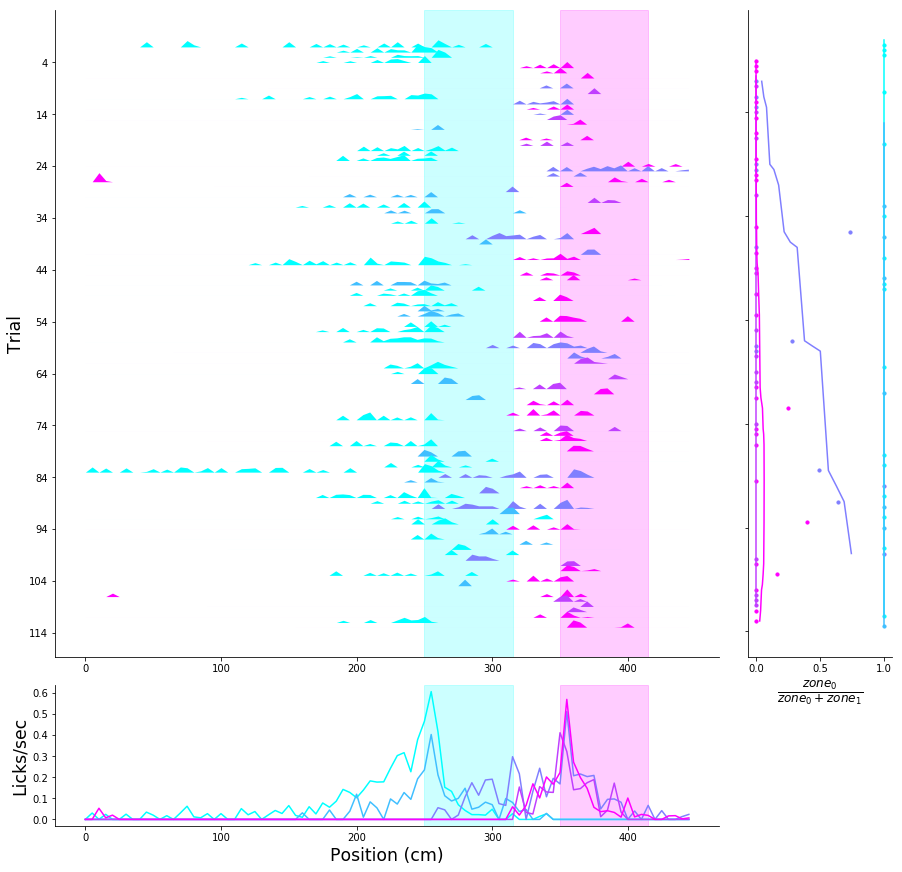

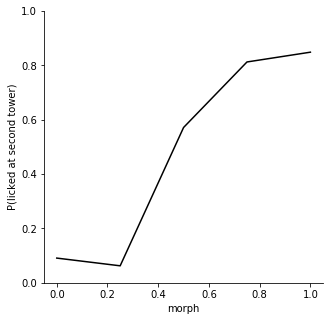

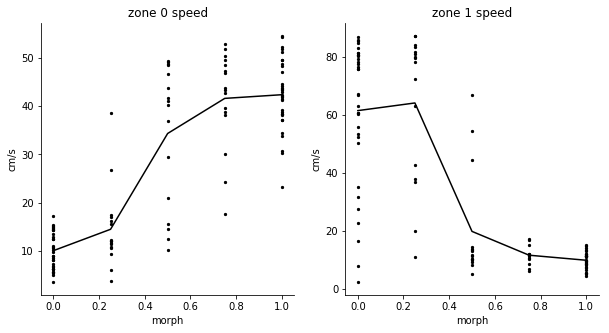

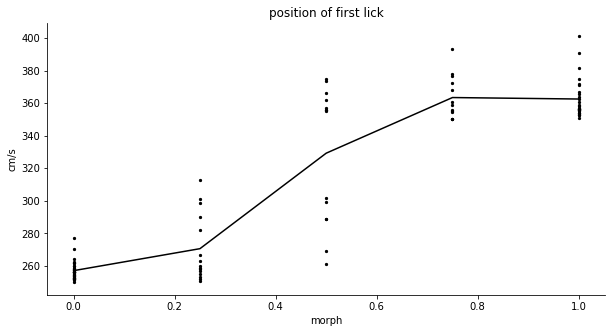

In [4]:
# load behavior and imaging data
behav = behavior_dataframe(sess['data file'],sess['scanmat'],concat=False)
tmp = run_behavior(behav,ratio = True)

info = loadmat_sbx(sess['scanmat'])['info']
ca_dat = load_ca_mat(sess['scanfile'])

C = ca_dat['C_dec'][info['frame'][0]:info['frame'][-1]+1]
S = ca_dat['S_dec'][info['frame'][0]:info['frame'][-1]+1]

frame_diff = behav.shape[0]-C.shape[0]
if frame_diff>0:
    behav = behav.iloc[:-frame_diff]
    
    
C_z = sp.stats.zscore(C,axis=0)
S_z = sp.stats.zscore(S,axis=0)
S_z_smooth = gaussian_filter1d(S_z,3,axis=0)
S_smooth = gaussian_filter1d(S,3,axis=0)

In [22]:
# find trial indices 
d = by_trial_info(behav)
extremeInds = np.where((d['morphs']==1 )| (d['morphs']==0))[0]
rewardedInds = np.where(d['rewards']>0)[0]
tstarts,tstops = np.where(behav['tstart']>0)[0],np.where(behav['teleport'])[0]

extremeRewarded = [i for i in extremeInds if i in rewardedInds]
#print(extremeRewarded)

tstarts_er = [tstarts[i] for i in extremeRewarded]
tstops_er = [tstops[i] for i in extremeRewarded]
print(tstarts_er)

C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:478: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])


[0, 1, 2, 3, 4, 5, 6, 10, 12, 15, 18, 20, 21, 22, 23, 26, 27, 31, 34, 36, 41, 42, 44, 45, 47, 48, 49, 50, 53, 54, 55, 57, 62, 63, 67, 69, 71, 72, 75, 76, 77, 78, 80, 81, 82, 85, 87, 88, 91, 92, 93, 95, 97, 98, 101, 102, 103, 106, 110, 111, 112]
[18, 651, 943, 1227, 1526, 1798, 2030, 3095, 3702, 4424, 5115, 5624, 5904, 6162, 6473, 7331, 9001, 9996, 11080, 11638, 13106, 13576, 14232, 14561, 15141, 15398, 15738, 15987, 16806, 17059, 17304, 17839, 19122, 19440, 20548, 20955, 21528, 21818, 22792, 23049, 23357, 23718, 24214, 24505, 25932, 27176, 27954, 28346, 29647, 30382, 30671, 31291, 31944, 32140, 32953, 33225, 33622, 34379, 35472, 35758, 36146]


dict_keys(['#refs#', '#subsystem#', 'A_keep', 'C_dec', 'C_keep', 'F0', 'F_dff', 'P', 'R_keep', 'S_dec', 'b', 'bl', 'f', 'options', 'template'])


In [ ]:
def LOO_inds(tstarts,tstops):
    trainInds,testInds = [],[]
    for i,(start,stop) in enumerate(zip(tstarts,tstops)):
        testInds.append([np.arange(start,stop)])
        
        tmp_train = []
        for j , (sstart,sstop) in enumerate(zip(tstarts,tstops)):
            if j!=i:
                tmp_train.extend(np.arange(sstart,sstop,dtype='int'))
        trainInds.append(tmp_train)
        
    return trainInds, testInds

train_er,test_er = LOO_inds(tstarts_er,tstops_er)


print(len(train),len(test))

# SVM classifier of context

In [18]:
# svm classifier for context including morphs


# LOO by trial
true_labels, pred_labels = [],[]
for ind, (i,o) in enumerate(zip(train_er,test_er)):
    svm = SVC(kernel='linear')
    data_train, labels_train = C[train_er,:], d['morphs'][train_er]
    data_test, labels_test = C[test_er,:], d['morphs'][test_er]
    svm.fit(data_train,labels_train)
    svm.predict(data_test)
    



#
#for i,(tr, te) in enumerate(zip(train,test)):
    
# 0 v 1 v morph


# all v all

# 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# simultaneous position context classifier - regularized multinomial or svm

# LOO by trial



In [ ]:


        
pos_binned = np.zeros(pos.shape)
bin_edges = np.arange(0,450,50).tolist()
bin_centers = [(bin_edges[k]+bin_edges[k+1])/2 for k in range(len(bin_edges)-1)]
for j,(edge1,edge2) in enumerate(zip(bin_edges[:-1],bin_edges[1:])):
    pos_binned[(pos>edge1) & (pos<=edge2)] = j+1

labels = pos_binned+ context*len(bin_edges)
        
        
        order = np.random.permutation(np.min([tstart_inds.shape[0],teleport_inds.shape[0]]))
        tstart_inds, teleport_inds = tstart_inds[order], teleport_inds[order]
        #print(np.max(tstart_inds),np.max(teleport_inds))
        mid_point = int(order.shape[0]*.5)
        trialList = []
        for start, stop in zip(tstart_inds,teleport_inds):
            #print(start,stop)
            trialList.append(np.arange(start,stop).tolist())
        
        
        train_inds = [j for i in trialList[:mid_point] for j in i]
        test_inds = [j for i in trialList[mid_point:] for j in i]
        
        
        if mouse == '4139190.1':
            LR = LogisticRegression(penalty = 'l2', solver = 'newton-cg',multi_class='multinomial',C=.1)
        else:
            LR = LogisticRegression(penalty = 'l2', solver = 'newton-cg',multi_class='multinomial',C=.001)
        LR.fit(C_dec[train_inds,:],labels[train_inds])
        
        print(mouse+":" + scan+ "mean accuracy %f" % LR.score(C_dec[test_inds,:], labels[test_inds]))

        cm = confusion_matrix(labels[test_inds],LR.predict(C_dec[test_inds,:]))
        f,ax = plt.subplots()
        f.suptitle(mouse+":" + scan)
        ax.imshow(cm)